In [1]:
import numpy as np
import pandas as pd

In [2]:
import datetime as dt
%matplotlib inline
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [37]:
from datetime import datetime, timedelta
from sqlalchemy.sql.expression import bindparam
from sqlalchemy import Interval
from dateutil.relativedelta import relativedelta
import datetime
from sqlalchemy import desc


# Design a query to retrieve the last 12 months of precipitation data and plot the results
#Get Max Date
max_date = session.query(Measurement.date).order_by(desc('date')).limit(1)
#max_date1 = dt.datetime.strptime(list(max_date), '%Y-%m-%d').date()

#min_date = max_date1 - timedelta(days=365)
#min_date1 = min_date.strftime(‘%Y-%m-%d’)


list(max_date)

#Hard code for now
max_date = '2017-08-23'
min_date = '2016-08-23'


In [40]:


#query data base
data_12Mo = session.query(Measurement.date, Measurement.station, Measurement.prcp, Measurement.tobs).filter(Measurement.date >= min_date, Measurement.date <= max_date)

df = pd.read_sql(data_12Mo.statement, session.bind)

# Calculate the date 1 year ago from the last data point in the database


# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

df = df.sort_values('date')
df.head()

# Use Pandas Plotting with Matplotlib to plot the data


,date,station,prcp,tobs
0,2016-08-23,USC00519397,0.00,81.0
1009,2016-08-23,USC00517948,NaN,80.0
1529,2016-08-23,USC00519281,1.79,77.0
704,2016-08-23,USC00514830,0.05,80.0
361,2016-08-23,USC00513117,0.15,76.0


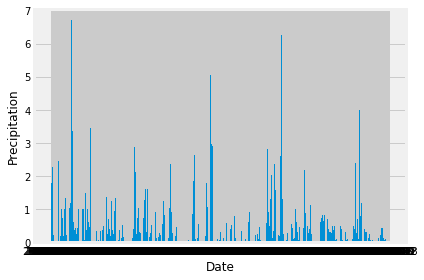

In [51]:
plt.bar(df['date'], df['prcp'])
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [53]:
# Use Pandas to calcualte the summary statistics for the precipitation data

df.describe()


,prcp,tobs
count,2021.000000,2230.000000
mean,0.177279,74.590583
std,0.461190,4.611667
min,0.000000,58.000000
25%,0.000000,72.000000
50%,0.020000,75.000000
75%,0.130000,78.000000
max,6.700000,87.000000


![describe](Images/describe.png)

In [54]:
# Design a query to show how many stations are available in this dataset?

nbr_stations = session.query(Measurement.station, func.count(Measurement.date).label('Obs')).group_by(Measurement.station)

nbr_stationsDF = pd.read_sql(nbr_stations.statement, session.bind)
nbr_stationsDF

,station,Obs
0,USC00511918,1979
1,USC00513117,2709
2,USC00514830,2202
3,USC00516128,2612
4,USC00517948,1372
5,USC00518838,511
6,USC00519281,2772
7,USC00519397,2724
8,USC00519523,2669


In [55]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

nbr_stationsDF = nbr_stationsDF.sort_values('Obs', ascending = False)

nbr_stationsDF


,station,Obs
6,USC00519281,2772
7,USC00519397,2724
1,USC00513117,2709
8,USC00519523,2669
3,USC00516128,2612
2,USC00514830,2202
0,USC00511918,1979
4,USC00517948,1372
5,USC00518838,511


In [56]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

max_min_temps = session.query(Measurement.station, func.max(Measurement.tobs).label('MaxTemp'),
                                func.min(Measurement.tobs).label('MinTemp'),
                                func.avg(Measurement.tobs).label('AvgTemp')).group_by(Measurement.station)

for x in max_min_temps:
    print(x.station,x.MaxTemp, x.MinTemp, x.AvgTemp)



USC00511918 87.0 53.0 71.61596766043456
USC00513117 85.0 59.0 72.68918420081211
USC00514830 85.0 58.0 74.8732970027248
USC00516128 84.0 58.0 70.91500765696784
USC00517948 87.0 58.0 74.68440233236151
USC00518838 83.0 58.0 72.72407045009784
USC00519281 85.0 54.0 71.66378066378067
USC00519397 87.0 56.0 74.55323054331865
USC00519523 85.0 56.0 74.5436493068565


<function matplotlib.pyplot.show(*args, **kw)>

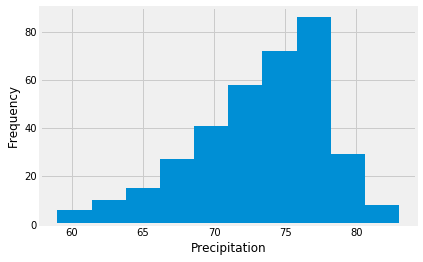

In [67]:
# Choose the station with the highest number of temperature observations.

top_station = nbr_stationsDF.iloc[0]['station']
top_station
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

top_station_12mo = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == top_station
                            ,Measurement.date >= min_date
                            ,Measurement.date <= max_date)

top_station_12moDF = pd.read_sql(top_station_12mo.statement, session.bind)

top_station_12moDF.head()

plt.hist(top_station_12moDF['tobs'])
plt.xlabel('Precipitation')
plt.ylabel('Frequency')
plt.show


![precipitation](Images/station-histogram.png)

In [68]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [69]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2011-02-28', '2011-03-05'))

[(61.0, 69.75510204081633, 75.0)]


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
